In [1]:
# Danny Alvarez's CNN model, modified. Meant to be run on Google Colab. 
# This file has been modified to address data imbalance.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import PIL
from PIL import Image

### Download Animal Images Dataset from Kaggle:

In [2]:
# Fetch dataset from kaggle:
! pip install -q kaggle
from google.colab import files
files.upload()  # upload kaggle.json API key (kaggle.com -> Account -> API -> click "Create New API Token" -> run this code block and upload kaggle.json file)

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dannyalvarez","key":"341b41ad04ab8dcce242b6122e21a232"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list    # Used to test if API is working. 

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                      COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           8788        259  1.0              
mattop/alcohol-consumption-per-capita-2016                     Alcohol Consumption Per Capita 2016                   4KB  2022-12-09 00:03:11            826         29  1.0              
thedevastator/jobs-dataset-from-glassdoor                      Salary Prediction                                     3MB  2022-11-16 13:52:31           5646        124  1.0              
swaptr/fifa-world-cup-2022-statistics                          FI

In [5]:
! kaggle datasets download -d alessiocorrado99/animals10  # Download the dataset

 99% 582M/586M [00:17<00:00, 37.2MB/s]
100% 586M/586M [00:17<00:00, 35.0MB/s]


In [6]:
! mkdir trainingdata
! unzip animals10.zip -d trainingdata   # Unzip dataset file

Streaming output truncated to the last 5000 lines.
  inflating: trainingdata/raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: trainingdata/raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: trainingdata/raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: trainingdata/raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: trainingdata/raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: trainingdata/raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: trainingdata/raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: trainingdata/raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: trainingdata/raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: trainingdata/raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: trainingdata/raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: trainingdata/raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: 

### Translate class names:

In [7]:
# Code to translate Italian class names to English. If this code block does
# not work, try deleting Google Colab runtime and redownloading dataset.

# Italian to English translations (since dataset class names come in Italian):
ital_to_engl = {"cane": "dog",
                "cavallo": "horse", 
                "elefante": "elephant", 
                "farfalla": "butterfly", 
                "gallina": "chicken", 
                "gatto": "cat", 
                "mucca": "cow", 
                "pecora": "sheep", 
                "scoiattolo": "squirrel",
                "ragno": "spider"}

# Translate folder names from Italian to English:
for key in ital_to_engl:
  if os.path.exists("/content/trainingdata/raw-img/" + key):
    os.rename("/content/trainingdata/raw-img/" + key ,"/content/trainingdata/raw-img/" + ital_to_engl[key])

# Remove unneeded file:
if os.path.exists("/content/trainingdata/translate.py"):
  os.remove("/content/trainingdata/translate.py")
else:
  print("File does not exist.")

### Load dataset:

26179


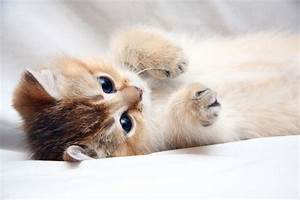

In [8]:
# Remember - dataset contains .jpeg, .jpg, .png
dataset_dir = pathlib.Path("/content/trainingdata/raw-img")

# Testing viewing the dataset:
image_count = len(list(dataset_dir.glob("*/*")))
print(image_count)    # Prints how many images there are.

kitties = list(dataset_dir.glob("cat/*"))
PIL.Image.open(str(kitties[0]))   # Displays first image in cats dataset.

['butterfly' 'cat' 'chicken' 'cow' 'dog' 'elephant' 'horse' 'sheep'
 'spider' 'squirrel']
11568
1446
1446


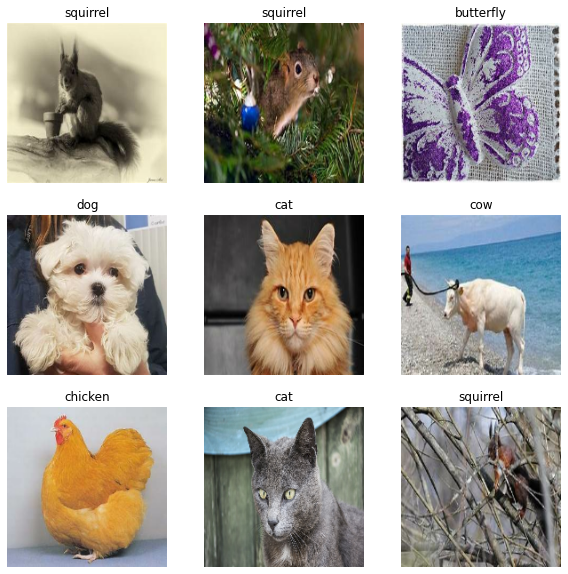

In [9]:
# Manually take same amount of images for each class so that there are the same
# amount of animal images for each animal class. Takes 1446 images for each class
# to match the total number of elephant images (1446), which has the lowest amount
# of images. 
list_ds_dog = tf.data.Dataset.list_files(str(dataset_dir/'dog/*'), shuffle=False)
list_ds_dog = list_ds_dog.shuffle(4863, reshuffle_each_iteration=False)
list_ds_dog = list_ds_dog.take(1446)
#print(list_ds_dog.cardinality().numpy())

list_ds_cat = tf.data.Dataset.list_files(str(dataset_dir/'cat/*'), shuffle=False)
list_ds_cat = list_ds_cat.shuffle(1668, reshuffle_each_iteration=False)
list_ds_cat = list_ds_cat.take(1446)
#print(list_ds_cat.cardinality().numpy())

list_ds_chicken = tf.data.Dataset.list_files(str(dataset_dir/'chicken/*'), shuffle=False)
list_ds_chicken = list_ds_chicken.shuffle(3098, reshuffle_each_iteration=False)
list_ds_chicken = list_ds_chicken.take(1446)
#print(list_ds_chicken.cardinality().numpy())

list_ds_spider = tf.data.Dataset.list_files(str(dataset_dir/'spider/*'), shuffle=False)
list_ds_spider = list_ds_spider.shuffle(4821, reshuffle_each_iteration=False)
list_ds_spider = list_ds_spider.take(1446)
#print(list_ds_spider.cardinality().numpy())

list_ds_horse = tf.data.Dataset.list_files(str(dataset_dir/'horse/*'), shuffle=False)
list_ds_horse = list_ds_horse.shuffle(2623, reshuffle_each_iteration=False)
list_ds_horse = list_ds_horse.take(1446)
#print(list_ds_horse.cardinality().numpy())

list_ds_butterfly = tf.data.Dataset.list_files(str(dataset_dir/'butterfly/*'), shuffle=False)
list_ds_butterfly = list_ds_butterfly.shuffle(2112, reshuffle_each_iteration=False)
list_ds_butterfly = list_ds_butterfly.take(1446)
#print(list_ds_butterfly.cardinality().numpy())

list_ds_elephant = tf.data.Dataset.list_files(str(dataset_dir/'elephant/*'), shuffle=False)
list_ds_elephant = list_ds_elephant.shuffle(1446, reshuffle_each_iteration=False)
list_ds_elephant = list_ds_elephant.take(1446)
#print(list_ds_elephant.cardinality().numpy())

list_ds_squirrel = tf.data.Dataset.list_files(str(dataset_dir/'squirrel/*'), shuffle=False)
list_ds_squirrel = list_ds_squirrel.shuffle(1862, reshuffle_each_iteration=False)
list_ds_squirrel = list_ds_squirrel.take(1446)
#print(list_ds_squirrel.cardinality().numpy())

list_ds_cow = tf.data.Dataset.list_files(str(dataset_dir/'cow/*'), shuffle=False)
list_ds_cow = list_ds_cow.shuffle(1866, reshuffle_each_iteration=False)
list_ds_cow = list_ds_cow.take(1446)
#print(list_ds_cow.cardinality().numpy())

list_ds_sheep = tf.data.Dataset.list_files(str(dataset_dir/'sheep/*'), shuffle=False)
list_ds_sheep = list_ds_sheep.shuffle(1820, reshuffle_each_iteration=False)
list_ds_sheep = list_ds_sheep.take(1446)
#print(list_ds_sheep.cardinality().numpy())

# Concatenate all equal sized classes into one dataset.
animals_ds = list_ds_dog.concatenate(list_ds_cat)
animals_ds = animals_ds.concatenate(list_ds_chicken)
animals_ds = animals_ds.concatenate(list_ds_spider)
animals_ds = animals_ds.concatenate(list_ds_horse)
animals_ds = animals_ds.concatenate(list_ds_butterfly)
animals_ds = animals_ds.concatenate(list_ds_elephant)
animals_ds = animals_ds.concatenate(list_ds_squirrel)
animals_ds = animals_ds.concatenate(list_ds_cow)
animals_ds = animals_ds.concatenate(list_ds_sheep)

# Make sure dataset is shuffled:
animals_ds = animals_ds.shuffle((1446 * 10), reshuffle_each_iteration=False)

class_names = np.array(sorted([item.name for item in dataset_dir.glob('*')]))
print(class_names)

# Split training and validation sets:
val_size = int((1446 * 10) * 0.2)
training_ds = animals_ds.skip(val_size)
validation_ds = animals_ds.take(val_size)

# Get test set from validation set:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 2)
validation_ds = validation_ds.skip(val_batches // 2)

# Show amount in each dataset:
print(training_ds.cardinality().numpy())
print(validation_ds.cardinality().numpy())
print(test_ds.cardinality().numpy())

def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

# define parameters for loader:
batch_size = 32
img_height = 180
img_width = 180

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
training_ds = training_ds.map(process_path, num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# Function to apply performance configs:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

training_ds = configure_for_performance(training_ds)
validation_ds = configure_for_performance(validation_ds)
test_ds = configure_for_performance(test_ds)

# Visualize some images:
image_batch, label_batch = next(iter(validation_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Data Preprocessing:

### Normalization:
(Rescaling pixel values so they lie within a confined range (0-1))

In [10]:
# Normalization layer (to be included in model):
normalization_layer = tf.keras.layers.Rescaling(1./255)

## Data Augmentation: (only do on training set)

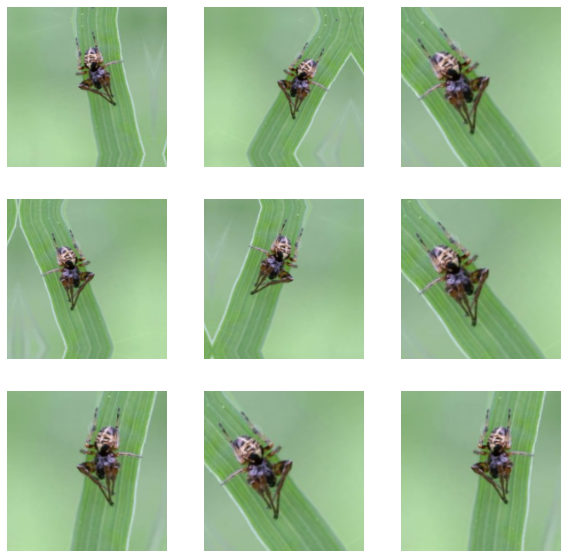

In [11]:
# Define data augmentation layers (to be included in model later):
# Includes: flipping, zooming, rotation
data_aug_layers = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

# Visualize some augmented examples:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
  for i in range(9):
    augmented_images = data_aug_layers(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Building CNN Model:

In [12]:
num_of_classes = len(class_names)

cnn_model = tf.keras.Sequential([
    normalization_layer,
    data_aug_layers,
    layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(filters = 256, kernel_size = 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(num_of_classes, activation = "softmax")
])

In [13]:
# Compile model:
cnn_model.compile(optimizer = "adam",
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["accuracy"])

In [14]:
# View all layers of network:
input_shape = (None, img_height, img_width, 3)
cnn_model.build(input_shape)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

## Training the Model:

In [15]:
epochs = 30
history = cnn_model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = epochs
)

Epoch 1/30
362/362 [==============================] - 36s 70ms/step - loss: 2.0730 - accuracy: 0.2368 - val_loss: 1.9064 - val_accuracy: 0.3237
Epoch 2/30
362/362 [==============================] - 21s 57ms/step - loss: 1.7312 - accuracy: 0.3856 - val_loss: 1.6896 - val_accuracy: 0.4212
Epoch 3/30
362/362 [==============================] - 21s 57ms/step - loss: 1.5560 - accuracy: 0.4537 - val_loss: 1.4091 - val_accuracy: 0.5028
Epoch 4/30
362/362 [==============================] - 21s 57ms/step - loss: 1.4215 - accuracy: 0.5098 - val_loss: 1.4109 - val_accuracy: 0.5083
Epoch 5/30
362/362 [==============================] - 21s 58ms/step - loss: 1.3241 - accuracy: 0.5378 - val_loss: 1.3739 - val_accuracy: 0.5401
Epoch 6/30
362/362 [==============================] - 21s 58ms/step - loss: 1.2476 - accuracy: 0.5723 - val_loss: 1.3354 - val_accuracy: 0.5539
Epoch 7/30
362/362 [==============================] - 21s 57ms/step - loss: 1.1781 - accuracy: 0.5915 - val_loss: 1.1916 - val_accuracy:

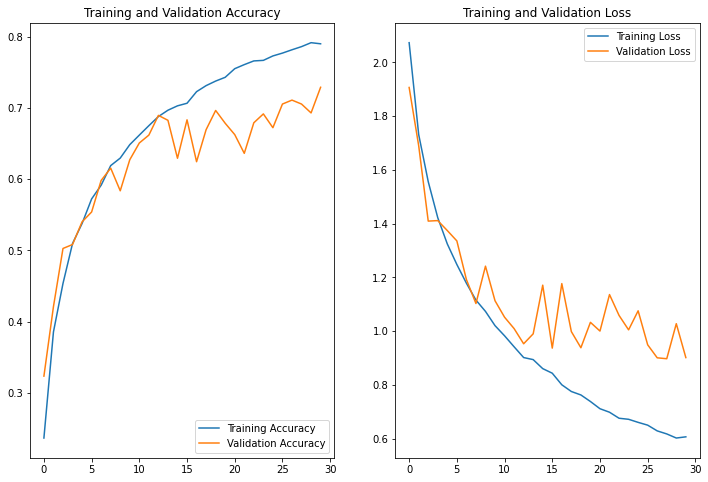

In [16]:
# Visualize training results:
accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
validation_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation:

In [17]:
results = cnn_model.evaluate(test_ds)
print("Test Loss, Test Accuracy:", results)

46/46 [==============================] - 2s 20ms/step - loss: 1.0388 - accuracy: 0.6929
Test Loss, Test Accuracy: [1.0388342142105103, 0.6929460763931274]
